In [7]:
import scipy
import matplotlib.pyplot as plt
import numpy as np

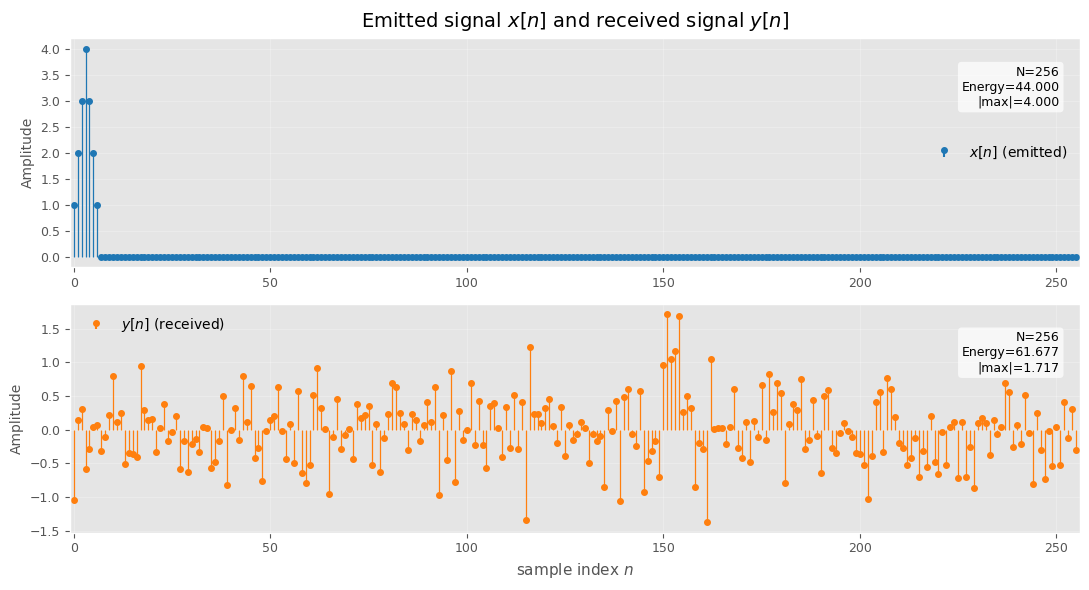

In [12]:
# ------------ Load signals from .mat -------------
mat = scipy.io.loadmat("signals.mat")  # adjust path if needed

def find_signal(matdict, prefer=()):
    """Try to find a 1-D signal array in the loaded .mat file.
       prefer: iterable of preferred variable names, e.g. ('x','y')"""
    # 1) exact preferred names
    for name in prefer:
        if name in matdict:
            return np.squeeze(matdict[name])
    # 2) common names
    for name in ('x', 'X', 'sig', 'signal', 'y', 'Y'):
        if name in matdict:
            return np.squeeze(matdict[name])
    # 3) fallback: first reasonable ndarray (not meta keys)
    candidates = [v for k, v in matdict.items() if not k.startswith("__") and isinstance(v, np.ndarray)]
    for v in candidates:
        if v.size > 1:
            return np.squeeze(v)
    raise ValueError("No suitable signal found in .mat file")

# extract x and y (tries sensible names)
x = find_signal(mat, prefer=('x',))
y = find_signal(mat, prefer=('y',))

# Make sure they're 1D numpy arrays
x = np.atleast_1d(x).astype(float).ravel()
y = np.atleast_1d(y).astype(float).ravel()

# indices
nx = np.arange(x.size)
ny = np.arange(y.size)

# simple stats for annotation
E_x = np.sum(x**2)
E_y = np.sum(y**2)
max_x = np.max(np.abs(x))
max_y = np.max(np.abs(y))

# ------------ plotting helper -------------
def plot_discrete(ax, n, sig, color, label):
    # If short, use stem; if long, use line + sparse markers
    if sig.size <= 300:
        markerline, stemlines, baseline = ax.stem(n, sig, linefmt=color, markerfmt='o', basefmt=' ')
        markerline.set_markersize(4)
        markerline.set_markerfacecolor(color)
        markerline.set_markeredgecolor(color)
        plt.setp(stemlines, 'linewidth', 0.9)
        baseline.set_linewidth(0.6)
    else:
        ax.plot(n, sig, color=color, linewidth=1)
        # overlay sparse markers so shape is visible
        stride = max(1, sig.size // 200)
        ax.plot(n[::stride], sig[::stride], 'o', color=color, markersize=4)
    ax.set_ylabel('Amplitude', fontsize=10)
    ax.legend([label], frameon=False, fontsize=10)

# ------------ Create figure -------------
#plt.style.use('')
fig, axs = plt.subplots(2, 1, figsize=(11, 6), sharex=False,
                        gridspec_kw={'height_ratios':[1,1]})

# Top: x[n]
plot_discrete(axs[0], nx, x, color='#1f77b4', label=r'$x[n]$ (emitted)')
axs[0].set_title(r'Emitted signal $x[n]$ and received signal $y[n]$', fontsize=14, pad=8)
axs[0].text(0.98, 0.88,
            f'N={x.size}\nEnergy={E_x:.3f}\n|max|={max_x:.3f}',
            transform=axs[0].transAxes, ha='right', va='top', fontsize=9,
            bbox=dict(boxstyle='round,pad=0.3', facecolor='white', alpha=0.7, edgecolor='none'))

# Bottom: y[n]
plot_discrete(axs[1], ny, y, color='#ff7f0e', label=r'$y[n]$ (received)')
axs[1].set_xlabel('sample index $n$', fontsize=11)
axs[1].text(0.98, 0.88,
            f'N={y.size}\nEnergy={E_y:.3f}\n|max|={max_y:.3f}',
            transform=axs[1].transAxes, ha='right', va='top', fontsize=9,
            bbox=dict(boxstyle='round,pad=0.3', facecolor='white', alpha=0.7, edgecolor='none'))

# Align x-limits nicely
common_max = max(nx[-1], ny[-1])
axs[0].set_xlim(-1, common_max + 1)
axs[1].set_xlim(-1, common_max + 1)

# subtle formatting
for ax in axs:
    ax.grid(alpha=0.25)
    ax.tick_params(axis='both', which='major', labelsize=9)

plt.tight_layout(h_pad=1.0)
plt.show()

# Optionally save
# fig.savefig("signals_x_y.png", dpi=200, bbox_inches='tight')


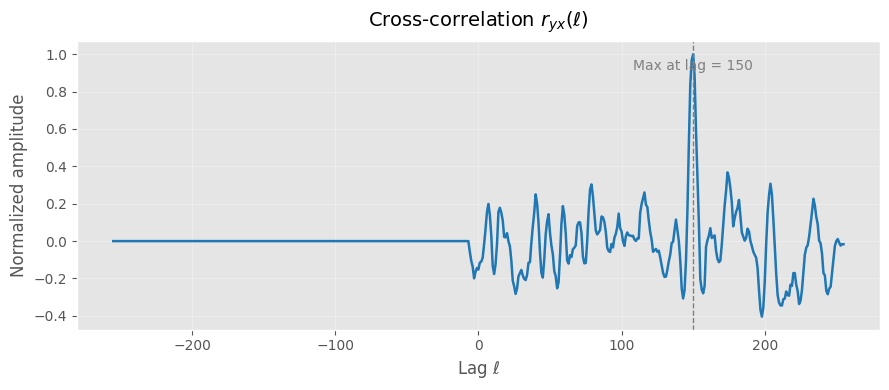

In [16]:
from scipy.signal import correlate

# --- Compute cross-correlation r_yx(l) ---
r_yx = correlate(y, x, mode='full')
lags = np.arange(-len(x) + 1, len(y))

# --- Normalize (optional, for better comparison) ---
r_yx_norm = r_yx / np.max(np.abs(r_yx))

# --- Plot ---
plt.style.use('ggplot')
plt.figure(figsize=(9, 4))
plt.plot(lags, r_yx_norm, color='#1f77b4', linewidth=1.8)

plt.title(r'Cross-correlation $r_{yx}(\ell)$', fontsize=14, pad=10)
plt.xlabel(r'Lag $\ell$', fontsize=12)
plt.ylabel(r'Normalized amplitude', fontsize=12)
plt.grid(alpha=0.3)

# highlight maximum correlation
max_idx = np.argmax(np.abs(r_yx))
plt.axvline(lags[max_idx], color='gray', linestyle='--', linewidth=1)
plt.text(lags[max_idx], 0.9, f'Max at lag = {lags[max_idx]}', 
         ha='center', va='bottom', fontsize=10, color='gray')

plt.tight_layout()
plt.show()


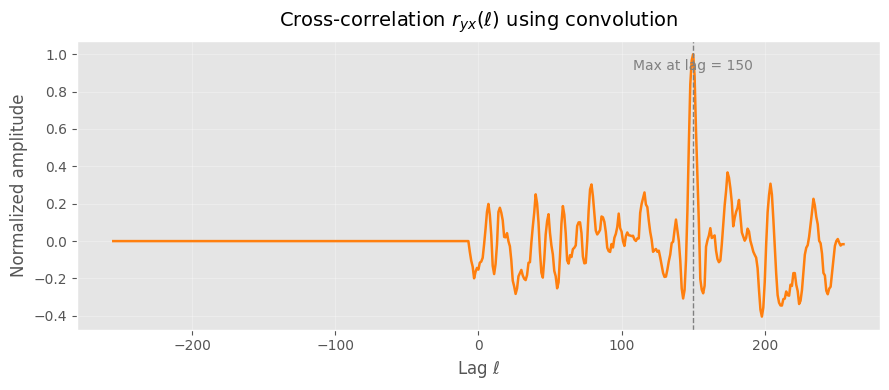

In [17]:

# --- Manual cross-correlation using convolution ---
# Flip x[n] -> x[-n]
x_flipped = np.flip(x)

# Convolve y[n] with x[-n]
r_yx_conv = np.convolve(y, x_flipped, mode='full')
lags_conv = np.arange(-len(x) + 1, len(y))

# Normalize (optional, for comparison)
r_yx_conv_norm = r_yx_conv / np.max(np.abs(r_yx_conv))

# --- Plot ---
plt.style.use('ggplot')
plt.figure(figsize=(9, 4))
plt.plot(lags_conv, r_yx_conv_norm, color='#ff7f0e', linewidth=1.8)
plt.title(r'Cross-correlation $r_{yx}(\ell)$ using convolution', fontsize=14, pad=10)
plt.xlabel(r'Lag $\ell$', fontsize=12)
plt.ylabel('Normalized amplitude', fontsize=12)
plt.grid(alpha=0.3)

# Highlight maximum correlation
max_idx = np.argmax(np.abs(r_yx_conv))
plt.axvline(lags_conv[max_idx], color='gray', linestyle='--', linewidth=1)
plt.text(lags_conv[max_idx], 0.9, f'Max at lag = {lags_conv[max_idx]}',
         ha='center', va='bottom', fontsize=10, color='gray')

plt.tight_layout()
plt.show()
